In [66]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [84]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect = True)

In [9]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [12]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [75]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
stats_2015 = calc_temps('2015-01-01','2015-12-31')[0]
print(stats_2015)

(56.0, 73.8603305785124, 86.0)


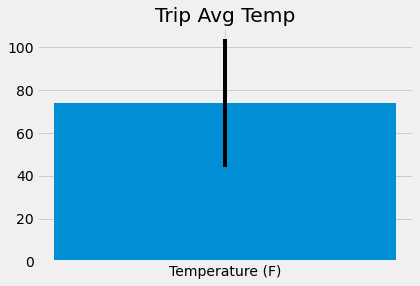

In [81]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = ([stats_2015[2]-stats_2015[0]])
plt.bar("Temperature (F)",stats_2015[1], yerr = error)
plt.title("Trip Avg Temp")
plt.show()

### Daily Rainfall Average

In [95]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

start_date2 = dt.datetime.strptime(start_date, '%Y-%m-%d').date()
end_date2 = dt.datetime.strptime(end_date, '%Y-%m-%d').date()


# Use the start and end date to create a range of dates
dates = []
def daterange(start, end):
    for n in range(int((end - start).days)+1):
        yield start + timedelta(n)

for date in daterange(start_date2, end_date2):
    dates.append(date)

# Put date trips back into string form for later use
trip_dates = []
for date in dates:
    trip_date = date.strftime('%Y-%m-%d')
    trip_dates.append(trip_date)


# query the total rainfall 
session.query(func.sum(Measurement.prcp), Measurement.station,\
        Station.name, Station.latitude, Station.longitude, Station.elevation).\
        join(Station, Measurement.station == Station.station).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

[(0.36, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 (0.22, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (0.06, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (0.04, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (0.0, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)]

### Daily Temperature Normals

In [16]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [55]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Strip off the year and save a list of strings in the format %m-%d
days = []
for date in dates:
    day = date.strftime('%m-%d')
    days.append(day)
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for day in days:
    norm = daily_normals(day)
    normals.append(norm[0])

In [59]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dictionary = {k: v for k, v in zip(trip_dates, normals)}

trip_df = pd.DataFrame.from_dict(dictionary, orient='index',
                       columns=['Minimum Temp', 'Average Temp', 'Maximum Temp'])
trip_df

,Minimum Temp,Average Temp,Maximum Temp
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


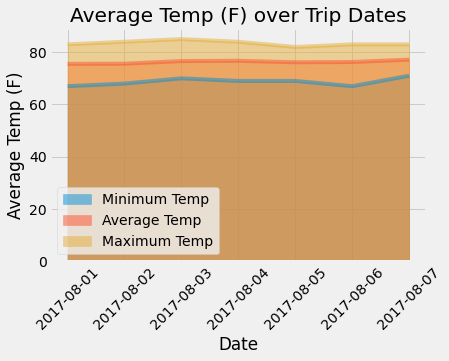

In [73]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot(kind = "area", stacked = False)
plt.title("Average Temp (F) over Trip Dates")
plt.ylabel("Average Temp (F)")
plt.xlabel("Date")
plt.xticks(rotation = 45)

plt.show()

## Close Session

In [74]:
session.close()